# End-to-end Training & Inference Script for YOLOv8 Object Detection Using Slicing Aided Hyper-Inference (SAHI)

This notebook is an end-to-end training and inference script for YOLOv8 object detection using SAHI. Training will be done on Datature Nexus. Do note that this notebook is solely for Object Detection use cases. For segmentation and other tasks, please contact our support team.

In [ ]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
"""
  ████
██    ██   Datature
  ██  ██   Powering Breakthrough AI
    ██

@File    :   yolov8_sahi.ipynb
@Author  :   Wei Loon Cheng
@Version :   1.0
@Contact :   hello@datature.io
@License :   Apache License 2.0
@Desc    :   End-to-end training and inference script for YOLOv8 using SAHI
"""


## Install Prerequisites

We will leverage Datature's Python SDK for data management and training, and the [SAHI library](https://github.com/obss/sahi) for data slicing and inference.

In [ ]:
%pip install -U sahi
%pip install -U datature
%pip install -U wget


In [1]:
import glob
import json
import logging
import os
import urllib
from collections import OrderedDict
from pathlib import Path
from pprint import pprint

from datature.nexus import Client, ApiTypes
from IPython.display import Image
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.slicing import slice_coco

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


## Downloading Images & Annotations

We assume that you already have an existing dataset consisting of images and annotations on Nexus that you want to convert to a SAHI project. If you want to create a new project, follow our [guide](https://developers.datature.io/docs/viewing-and-adding-assets) to onboarding your dataset.

The project Secret Key can be found in the **Integrations** tab on your Nexus project page. Check out how to locate it [here](https://developers.datature.io/docs/project-keys-and-secret-keys).

In [2]:
# Change this to your project secret key to the new project you want to upload your sliced images to
# It can be located on Nexus under the Integrations tab in your project page
SECRET_KEY = "<YOUR_SECRET_KEY>"

# Change this to your project ID on Nexus. This can be found via two methods:
# 1. In the URL of the project page (https://nexus.datature.io/project/<YOUR_PROJECT_ID>)
# 2. Project Key in the Integrations page
PROJECT_ID = "proj_<YOUR_PROJECT_ID>"

In [3]:
client = Client(SECRET_KEY)
project = client.get_project(PROJECT_ID)

### Download images

In [5]:
# Change this to the directory you want to store your images
image_dir = Path("images")
os.makedirs(image_dir, exist_ok=True)

# Download images from Nexus
print("Downloading images from Nexus...")
urls = []
assets = project.assets.list({"limit": 100})
urls.extend([(asset["filename"], asset["url"]) for asset in assets["data"]])
next_page = assets["next_page"]

while next_page:
    assets = project.assets.list(
        {
            "limit": 100,
            "page": next_page,
        }
    )
    urls.extend([(asset["filename"], asset["url"]) for asset in assets["data"]])
    next_page = assets["next_page"]

for filename, url in urls:
    urllib.request.urlretrieve(url, os.path.join(image_dir, filename))
print(f"{len(urls)} images saved to: {image_dir}")


100 images saved to: images


### Download annotations

In [6]:
print("Downloading annotations from Nexus...")
annotation_dir = Path("annotations")
annotation_export_metadata = ApiTypes.AnnotationExportMetadata(
    # change this to your desired annotation format
    # supported formats are listed here
    # https://developers.datature.io/docs/types-sdk-functions#annotationformat
    format="coco",
    options=ApiTypes.AnnotationExportOptions(
        # 0.0 means all annotations are stored in the same file,
        # change this value if you want a train-test split
        split_ratio=0.0,
        normalized=False,
        seed=0,
    ),
)
operation = project.annotations.create_export(annotation_export_metadata)
project.operations.wait_until_done(operation["id"])
annotation_results = project.annotations.download_exported_file(
    operation["id"], annotation_dir
)
annotation_filename = annotation_results["file_names"][-1]
print(f"Annotations saved to: {annotation_filename}")

Annotations saved to: 41b8e35ec179b34adf19e3c670daa3de/dump.json


### Visualize image

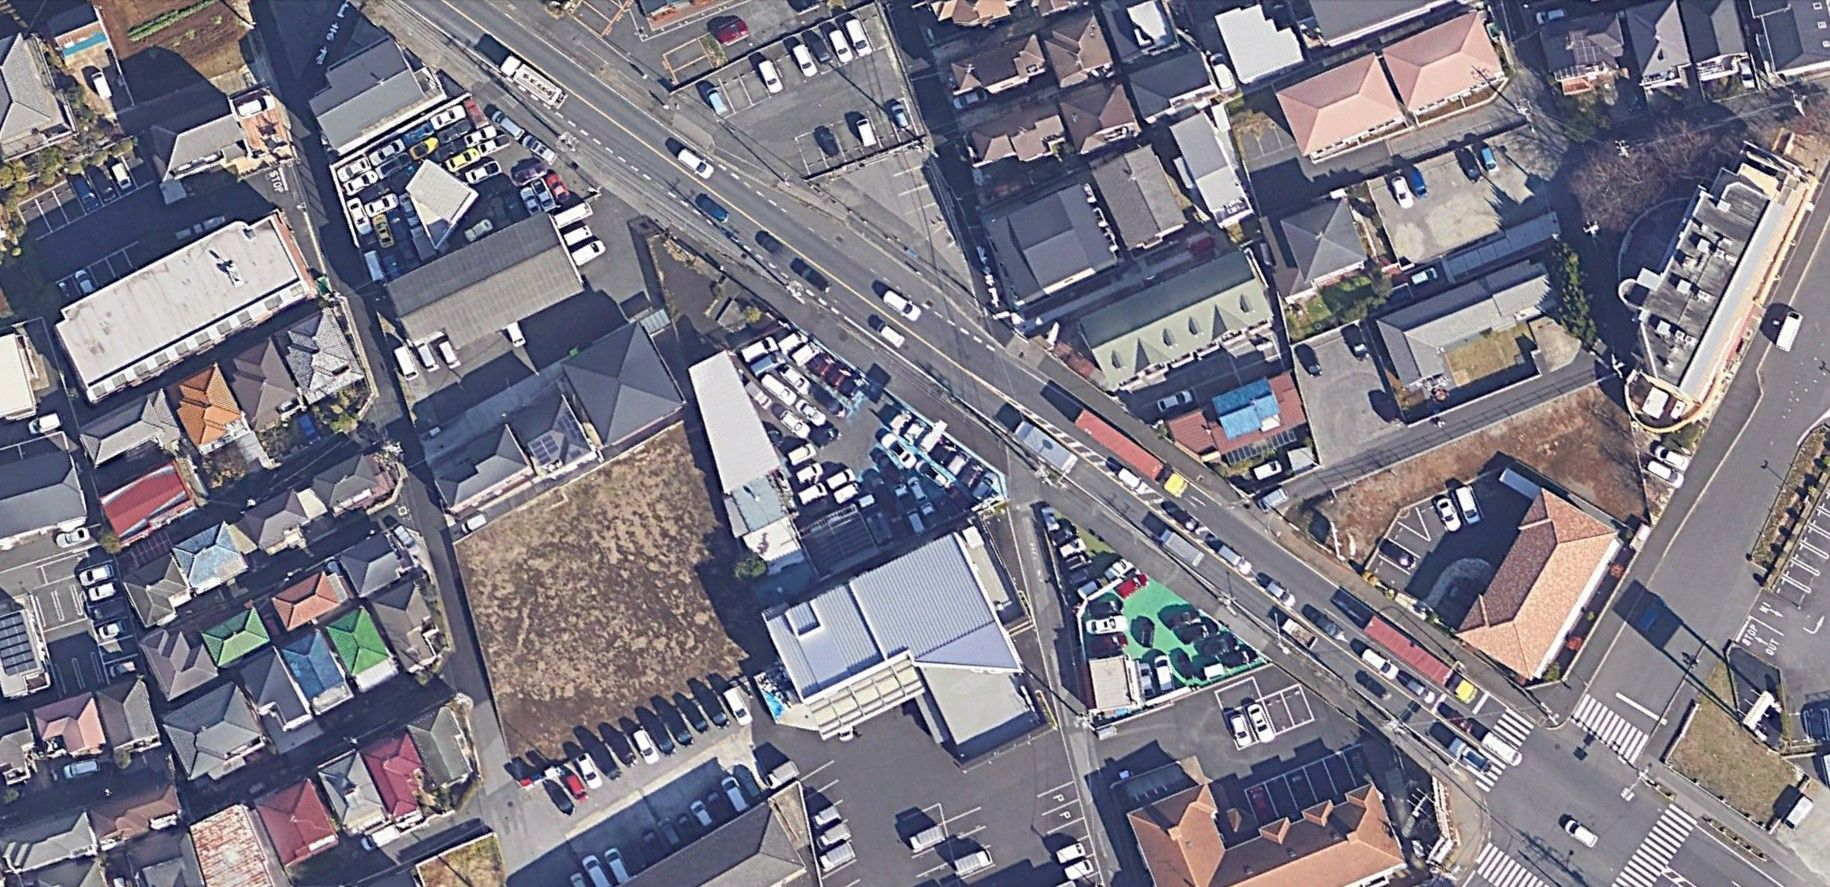

In [7]:
sample_image = os.listdir(image_dir)[0]
Image(os.path.join(image_dir, sample_image))

## Image Slicing with SAHI

We use the SAHI library to slice each image in the dataset into smaller images based on user-defined parameters. Then, we slice the annotations in a similar fashion and filter out sliced images with no annotations to reduce the overall size of the new dataset.

### Slice images

In [8]:
SLICE_HEIGHT = 320
SLICE_WIDTH = 320
sliced_data_dir = Path("sliced_data")

slice_results = slice_coco(
    coco_annotation_file_path=os.path.join(annotation_dir, annotation_filename),
    image_dir=str(image_dir),
    output_coco_annotation_file_name="sliced",
    output_dir=str(sliced_data_dir),
    slice_height=SLICE_HEIGHT,
    slice_width=SLICE_WIDTH,
    ignore_negative_samples=True,
    verbose=False,
)
print(f"{len(os.listdir(sliced_data_dir)) - 1} slices saved to: {sliced_data_dir}")


indexing coco dataset annotations...


Loading coco annotations:   0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


2804 slices saved to: sliced_data


### Filter images with no annotations

In [9]:
ext = ["png", "jpg"]
image_paths = []
[
    image_paths.extend(glob.glob(os.path.join(str(sliced_data_dir), f"*.{e}")))
    for e in ext
]
filtered_image_paths = []

with open(
    os.path.join(sliced_data_dir, "sliced_coco.json"), "r", encoding="utf-8"
) as f:
    sliced_coco = json.load(f)
    image_ids = set(
        [annotation["image_id"] for annotation in sliced_coco["annotations"]]
    )
    for image_path in image_paths:
        image_id = next(
            (
                image["id"]
                for image in sliced_coco["images"]
                if image["file_name"] == os.path.basename(image_path)
            ),
            None,
        )
        if image_id in image_ids:
            filtered_image_paths.append(image_path)
print("Total filtered images:", len(filtered_image_paths))


Total filtered images: 2480


### Visualize a slice

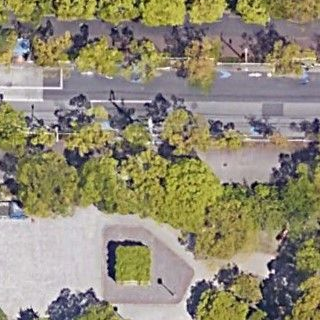

In [10]:
sample_image = os.listdir(sliced_data_dir)[0]
Image(os.path.join(sliced_data_dir, sample_image))


## Uploading Sliced Data to Nexus

In this tutorial, we create a new project on Nexus for uploading the sliced data. You can also upload the new data back to your existing project, under a different [asset group](https://developers.datature.io/docs/asset-group-management).

In [4]:
# Change this to your project secret key to the new project you want to upload your sliced images to
# It can be located on Nexus under the Integrations tab in your project page
SAHI_SECRET_KEY = "<YOUR_SECRET_KEY>"

# Change this to your project ID on Nexus. This can be found via two methods:
# 1. In the URL of the project page (https://nexus.datature.io/project/<YOUR_PROJECT_ID>)
# 2. Project Key in the Integrations page
SAHI_PROJECT_ID = "proj_<YOUR_PROJECT_ID>"

sahi_client = Client(SAHI_SECRET_KEY)
sahi_project = sahi_client.get_project(SAHI_PROJECT_ID)

### Upload sliced images

In [40]:
print("Uploading sliced images...")
# split into batches of 1000 images
batch_count = 1
for i in range(0, len(filtered_image_paths), 1000):
    batch = image_paths[i : i + 1000]
    upload_session = sahi_project.assets.create_upload_session(groups=["sliced"])
    with upload_session:
        for image in batch:
            upload_session.add_path(str(image))
    upload_session.wait_until_done()
    print(f"Uploaded {len(batch) * batch_count} images")
    batch_count += 1
print("Upload to Nexus completed!")


Uploading sliced images...
Uploaded 1000 images
Uploaded 2000 images
Uploaded 2412 images
Upload to Nexus completed!


### Upload sliced annotations

In [41]:
print("Uploading sliced annotations...")
import_session = sahi_project.annotations.create_import_session()
with import_session:
    import_session.add_path(os.path.join(sliced_data_dir, "sliced_coco.json"))
import_session.wait_until_done()
print("Upload to Nexus completed!")

Uploading sliced annotations...
Upload to Nexus completed!


## Model Training

Once the sliced data and annotations have been successfully uploaded to Nexus, it's time to kickstart a model training. If you have not created a training workflow, navigate to the workflow tab in Nexus and customize your new workflow. If you have already created a workflow, you can skip this step.

Then, we customize the training setup and start the training. You can monitor the training progress in Nexus by tracking the [metrics curves](https://developers.datature.io/docs/evaluating-model-performance) or visualizing predictions with our [advanced evaluation preview](https://developers.datature.io/docs/advanced-evaluation-for-model-performance).

In [12]:
# we assume that there is only one workflow in the project
flow_id = sahi_project.workflows.list()[-1]["id"]
training_setup = ApiTypes.RunSetupMetadata(
    accelerator=ApiTypes.Accelerator(
        name="GPU_T4",
        count=1,
    ),
    checkpoint=ApiTypes.Checkpoint(
        strategy="STRAT_HIGHEST_ACCURACY",
        metric="DetectionBoxes_Precision/mAP@.50IOU",
        evaluation_interval=500,
    ),
    limit=ApiTypes.Limit(
        metric="LIM_NONE",
        value=0,
    ),
    preview=True,
    matrix=True,
)
run_response = sahi_project.runs.start(flow_id, training_setup)

# Model Export & Download

Once the training has completed, we can export the model and download it to our local machine. You can also create a [deployment](https://developers.datature.io/docs/deploying-your-trained-model-as-an-api) where we will host your model on our cloud servers, and you can make API calls to run inference.

In [5]:
artifact_id = sahi_project.artifacts.list()[-1]["id"]
try:
    export_options = {
        "format": "PyTorch",
    }
    model_id = sahi_project.artifacts.create_export(artifact_id, export_options)["id"]
except:
    model_id = sahi_project.artifacts.list_exported_models(artifact_id)[-1]["id"]
print("Artifact ID:", artifact_id)
print("Model ID:", model_id)

Artifact ID: artifact_65c1968ef4c27937bf4dad04
Model ID: model_yq8qxx37480x7r60452y2rrvvx92v218


In [6]:
model_dir = Path("models")
model_response = sahi_project.artifacts.download_exported_model(model_id, model_dir)
model_path = os.path.join(model_dir, model_response["model_filename"])
label_path = os.path.join(model_dir, model_response["label_filename"])
print(f"Model {model_path} download complete!")

Model models/datature-yolov8s.pt download complete!


# Model Inference

We can now use the exported model, together with the SAHI library, to run inference on a full-sized image. We will also visualize the predictions on the image to see how well the model performs.

### Read label map to load classes

In [7]:
label_map = OrderedDict()
with open(label_path, "r", encoding="utf-8") as label_map_file:
    for line in label_map_file:
        if "id" in line:
            label_index = line.split(":")[-1].strip()
            if label_index == "0":
                continue
            label_name = next(label_map_file).split(":")[-1].strip().strip('"')
            label_map[label_index] = label_name
pprint(label_map)


OrderedDict([('1', 'Pickup Truck'),
             ('2', 'Truck with Trailer'),
             ('3', 'Car'),
             ('4', 'Truck'),
             ('5', 'Van'),
             ('6', 'Bicycle'),
             ('7', 'Miscellaneous'),
             ('8', 'Motorbike'),
             ('9', 'Road'),
             ('10', 'Bus'),
             ('11', 'Car-Trailer')])


### Load model

In [8]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=model_path,
    confidence_threshold=0.7,
    device="cpu", # or 'cuda:0' if you want to use GPU
    category_mapping=label_map,
)


### Run prediction on a full-sized image

Performing prediction on 28 number of slices.


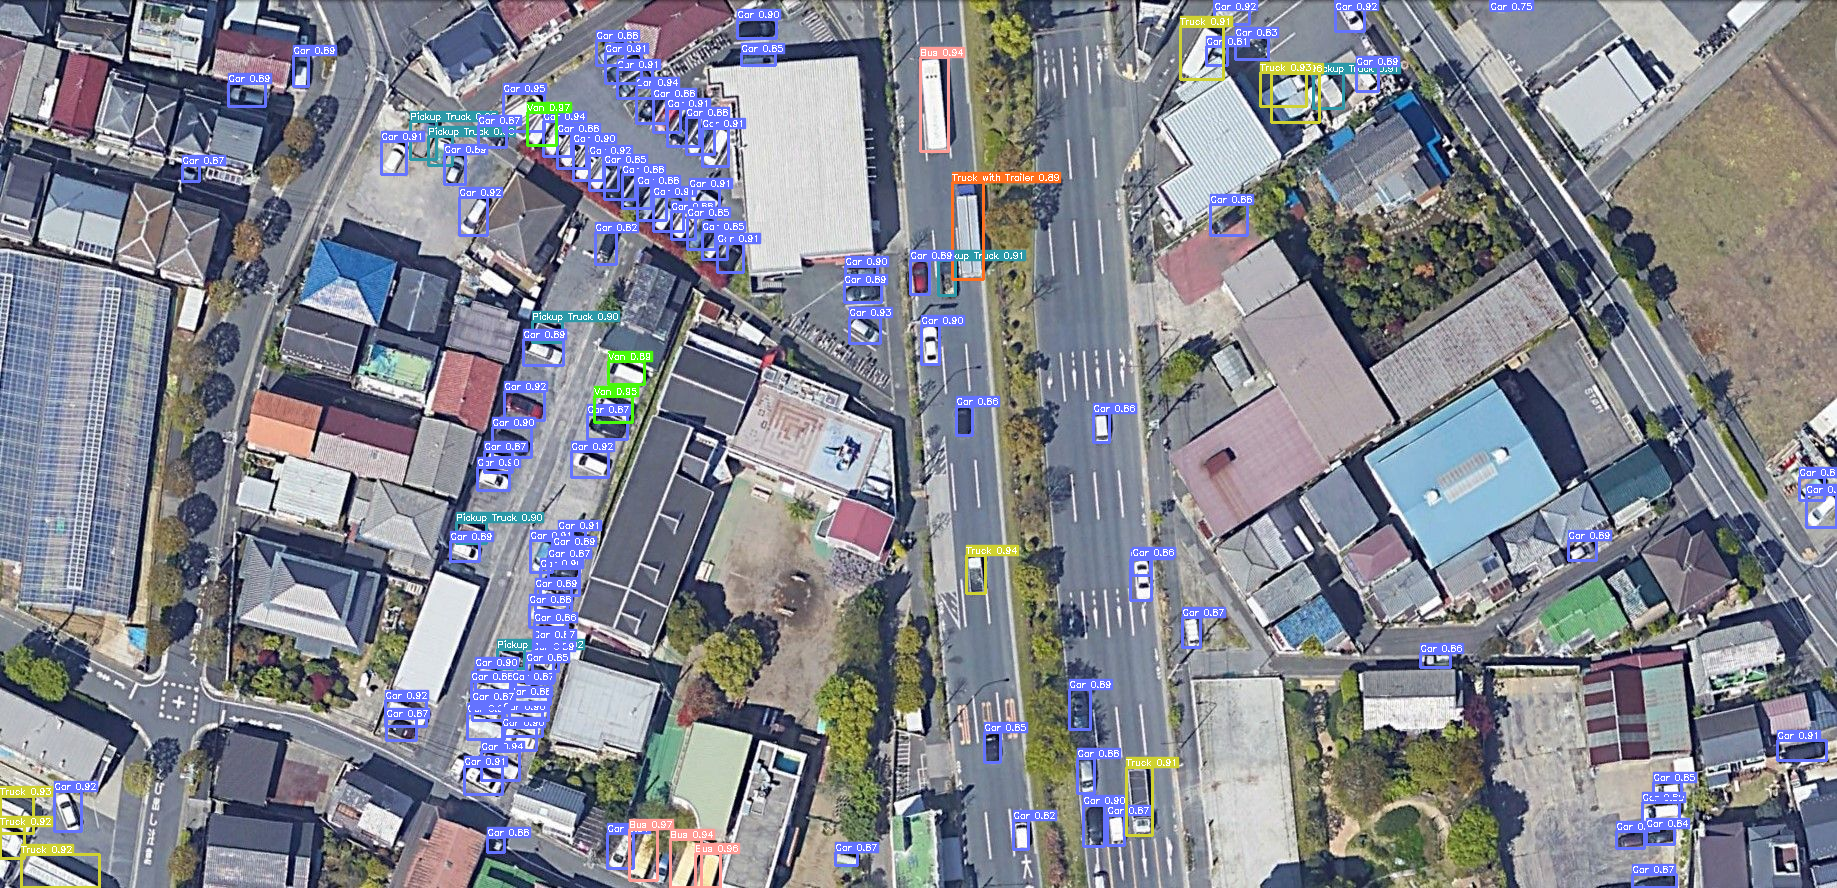

In [9]:
predict_image_path = "images/Screenshot 2022-09-02 182050.jpg"
result = get_sliced_prediction(
    predict_image_path,
    detection_model,
    slice_height=320,
    slice_width=320,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)
result.export_visuals(export_dir="predict_data/", text_size=0.3, rect_th=2)
Image("predict_data/prediction_visual.png")
